## Alura Voz : Challenge Data Science

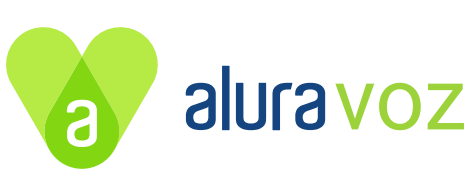

In [2]:
from IPython.display import Image
from IPython.core.display  import HTML
Image('alura_voz.png')

__Desafio Alura Challenge Data Science__ para desenvolver um conjunto de análises e modelos de machine learning supervisionado para auxiliar o time de vendas da empresa __Alura Voz__ a fidelizar clientes.

A Alura Voz é uma empresa de telecomunicação que nos contratou para atuar como cientistas de dados na equipe de vendas. Precisamos realizar um estudo quanto ao __Churn__ da empresa. O churn indica se um cliente cancelou ou não o contrato com a empresa, e nos ajuda a entender a receita final da empresa.

## Dados

Ao observar a Base de dados da Alura Voz, verificamos que essa é uma base disponibilizada via API em formato JSON com várias camandas de dados.

Junto a esses dados também foi disponibilizado o dicionário dos dados que nele contém todas as informações sobre as colunas do banco de dados.

Nela, além da informação se o cliente deixou ou não a empresa, também contém:

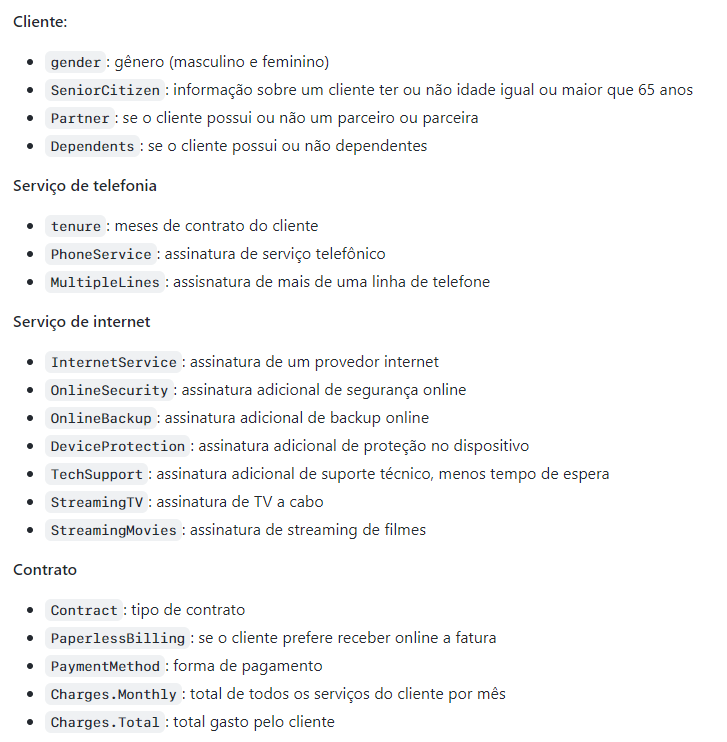

In [3]:
Image('dados_descricao.png')

Tendo essas informações entendemos nossos dados e, assim, podemos realizar uma análise mais técnica, buscando entender JSON, os dados e realizar o tratamento deles.

## Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import math
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:100% !important;}</style>'))
pd.options.display.float_format = '{:.5f}'.format

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn import metrics

## Loading Data

In [5]:
df = pd.read_json('Telco-Customer-Churn.json')

## Descrição dos Dados

In [6]:
df1 = df.copy()
df1.head()

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."


## Data Dimensions

In [7]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 7267
Número de colunas: 6


## Check NA

In [8]:
df1.isna().sum()

customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64

## Change Data Type

> No DataSet podemos observar que temos __Dicts__ com dados __categóricos__ e __numéricos__, precisamos extrair esses Dicts para novas colunas e mudar a coluna Churn para númerico, e outras colunas também se caso precisar ou para categórico ou para numérico. Poderia usar o json_normalize para extrair os dicts, mas quero fazer de outra forma.

### Churn

In [9]:
df1.Churn.value_counts()

No     5174
Yes    1869
        224
Name: Churn, dtype: int64

> Há um erro aqui, o __value_counts()__ contabilizou __224__ valores ausentes. Vamos excluir, aí então vamos mudar os dados Churn para númericos.

In [10]:
le = LabelEncoder()
df1['Churn']=le.fit_transform(df1['Churn'])

In [11]:
nan_value = math.isnan(np.nan)
df1.replace(0, nan_value, inplace = True)
df1.dropna(how = 'all', axis = 1, inplace = True)

In [12]:
df1.Churn = pd.to_numeric(df1.Churn, errors = 'coerce')

In [13]:
df1.Churn.value_counts()

1    5398
2    1869
Name: Churn, dtype: int64

In [14]:
df1.dtypes

customerID    object
Churn          int64
customer      object
phone         object
internet      object
account       object
dtype: object

> Agora sim, os dados de Churn foram consertados, agora vamos extrair os Dicts das colunas customer, phone, internet e account, e gerar um Data

## FEATURE ENGINEERING

### Criação das novas colunas dos dicts: [customer, phone, internet, account]

In [15]:
df2 = df1.copy()
df2 = df2.iloc[:, 1:]

In [16]:
# Exemplo de quais chaves estão no dict customer.

for i in df2.customer[0]:
    print(i)

gender
SeniorCitizen
Partner
Dependents
tenure


In [17]:
lst_dicts = ['customer', 'phone', 'internet', 'account']

def create_columns(data):
    for i in df2[data][0]:
        df2[i] = df2[data].str.get(i)
    return data

for i in lst_dicts:
    create_columns(i)

> Colunas criadas, mas ainda há na coluna CHARGES dicts para serem extraídos.

In [18]:
for i in df2.Charges[0]:
    df2[i] = df2['Charges'].str.get(i)

> Pronto. Agora precisamos renomear as colunas Monthly e Total e excluir as colunas desnecessárias.

In [19]:
df2.rename(columns = {'Monthly':'charges_monthly','Total':'charges_total'}, inplace = True)

In [20]:
cols_drop = ['customer', 'phone', 'internet', 'account', 'Charges']
df2 = df2.drop(cols_drop, axis = 1)

### Mudando os dados para numéricos em SeniorCitizen

In [21]:
df2.SeniorCitizen = df2.SeniorCitizen.map({0:'No', 1:'Yes'})

### Mudando os dados de charge_total para numérico.

In [22]:
df2.charges_total = pd.to_numeric(df2.charges_total, errors = 'coerce')

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Churn             7267 non-null   int64  
 1   gender            7267 non-null   object 
 2   SeniorCitizen     7267 non-null   object 
 3   Partner           7267 non-null   object 
 4   Dependents        7267 non-null   object 
 5   tenure            7267 non-null   int64  
 6   PhoneService      7267 non-null   object 
 7   MultipleLines     7267 non-null   object 
 8   InternetService   7267 non-null   object 
 9   OnlineSecurity    7267 non-null   object 
 10  OnlineBackup      7267 non-null   object 
 11  DeviceProtection  7267 non-null   object 
 12  TechSupport       7267 non-null   object 
 13  StreamingTV       7267 non-null   object 
 14  StreamingMovies   7267 non-null   object 
 15  Contract          7267 non-null   object 
 16  PaperlessBilling  7267 non-null   object 


### Verificando dados NA em df2

In [24]:
df2.isna().sum()

Churn                0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
charges_monthly      0
charges_total       11
dtype: int64

> O DATASET POSSUI 11 VALORES AUSENTES NA COLUNA charges_total, vou substituir esses valores pela média de charges_total.

In [25]:
df2['charges_total'].fillna((df2['charges_total'].mean()), inplace = True)

In [26]:
df2.isna().sum()

Churn               0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
charges_monthly     0
charges_total       0
dtype: int64

## Análise Exploratória dos Dados

### Análise Univariada - Variável Resposta

In [27]:
df2.Churn.value_counts()

1    5398
2    1869
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Churn', ylabel='count'>

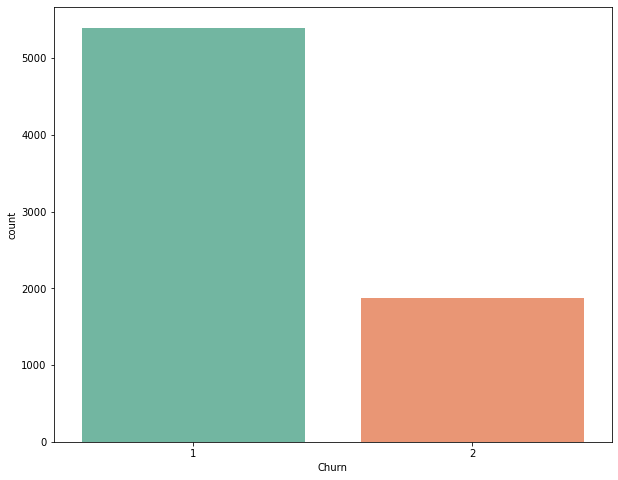

In [28]:
# CHURN
plt.figure(figsize = (10,8))
sns.countplot(data = df2, x = 'Churn', palette = 'Set2')

### Análise Bivariada - Criação de Hipóteses

#### H1. Mulheres cancelam mais contratos do que os homens.

In [29]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['gender']).count()

gender
Female    939
Male      930
Name: Churn, dtype: int64

<AxesSubplot:xlabel='gender,Churn'>

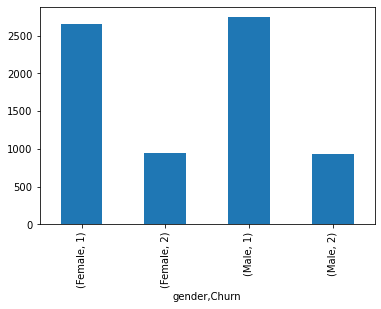

In [30]:
df2.groupby('gender')['Churn'].value_counts().plot(kind = 'bar')

> R: Mulheres fizeram mais cancelamentos do que os homens, mas a diferença foi insignificante, 939 para as mulheres, e 930 para os homens, então o genêro não influencia no Churn.

#### H2. Idosos fazem mais cancelamentos.

In [31]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['SeniorCitizen']).count()

SeniorCitizen
No     1393
Yes     476
Name: Churn, dtype: int64

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

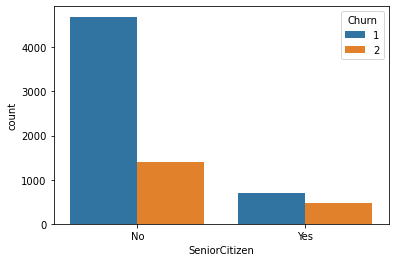

In [32]:
sns.countplot(x = 'SeniorCitizen', hue = 'Churn', data = df2)

> R: Idosos não fazem muitos cancelamentos.

#### H3. Parceiros fazem mais cancelamentos.

In [33]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['Partner']).count()

Partner
No     1200
Yes     669
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Partner', ylabel='count'>

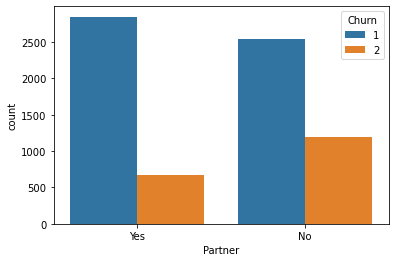

In [34]:
sns.countplot(x = 'Partner', hue = 'Churn', data = df2)

> R: Parceiros fazem menos cancelamentos do que solteiros.

#### H4. Dependentes fazem mais cancelamentos.

In [35]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['Dependents']).count()

Dependents
No     1543
Yes     326
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Dependents', ylabel='count'>

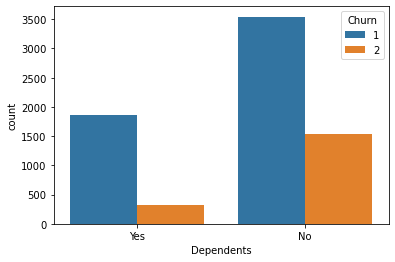

In [36]:
sns.countplot(x = 'Dependents', hue = 'Churn', data = df2)

> R: Dependentes fazem menos cancelamentos do que não dependentes.

#### H5. Clientes mais novos cancelam mais os serviços.

In [37]:
fig = px.box(df2, x='Churn', y = 'tenure')

fig.update_yaxes(title_text='Tenure (Months)', row=1, col=1)
fig.update_xaxes(title_text='Churn', row=1, col=1)
fig.update_layout(autosize=True, width=750, height=600,
    title_font=dict(size=25, family='Courier'),
    title='<b>Tenure vs Churn</b>',
)

fig.show()

> R: Novos clientes são mais propensos a cancelamentos.

#### H6. Quem tem PhoneService faz mais cancelamentos. 

In [38]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['PhoneService']).count()

PhoneService
No      170
Yes    1699
Name: Churn, dtype: int64

<AxesSubplot:xlabel='PhoneService', ylabel='count'>

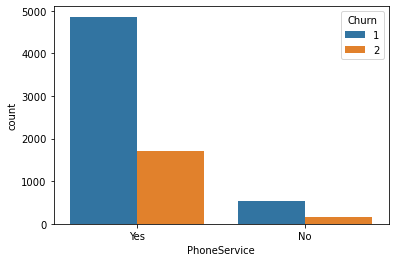

In [39]:
sns.countplot(x = 'PhoneService', hue = 'Churn', data = df2)

> R: Quem tem PhoneService faz mais cancelamentos.

#### H7. Quem tem MultipleLines faz mais cancelamentos.

In [40]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['MultipleLines']).count()

MultipleLines
No                  849
No phone service    170
Yes                 850
Name: Churn, dtype: int64

<AxesSubplot:xlabel='MultipleLines', ylabel='count'>

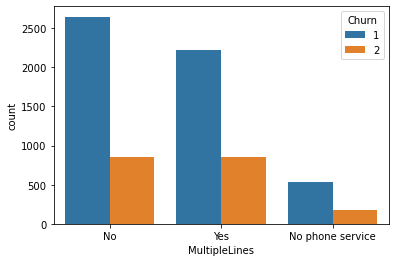

In [41]:
sns.countplot(x = 'MultipleLines', hue = 'Churn', data = df2)

> R: Quem tem MultipleLines fez praticamente a mesma quantidade de cancelamentos de quem não tem MultipleLines. 

#### H8. Quem tem InternetService fez mais cancelamentos.

In [42]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['InternetService']).count()

InternetService
DSL             459
Fiber optic    1297
No              113
Name: Churn, dtype: int64

<AxesSubplot:xlabel='InternetService', ylabel='count'>

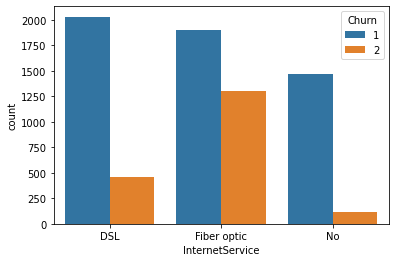

In [43]:
sns.countplot(x = 'InternetService', hue = 'Churn', data = df2)

> R: Quem tem fibra óptica fez mais cancelamentos do que quem tem InternetService tipo DSL e quem não tem nenhum InternetService.

#### H9. Quem tem OnlineSecurity faz mais cancelamentos.

In [44]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['OnlineSecurity']).count()

OnlineSecurity
No                     1461
No internet service     113
Yes                     295
Name: Churn, dtype: int64

<AxesSubplot:xlabel='OnlineSecurity', ylabel='count'>

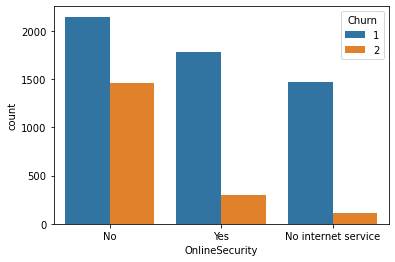

In [45]:
sns.countplot(x = 'OnlineSecurity', hue = 'Churn', data = df2)

> R: Quem não tem OnlineSecurity fez mais cancelamentos.

#### H10. Quem tem OnlineBackup fazem mais cancelamentos.

In [46]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['OnlineBackup']).count()

OnlineBackup
No                     1233
No internet service     113
Yes                     523
Name: Churn, dtype: int64

<AxesSubplot:xlabel='OnlineBackup', ylabel='count'>

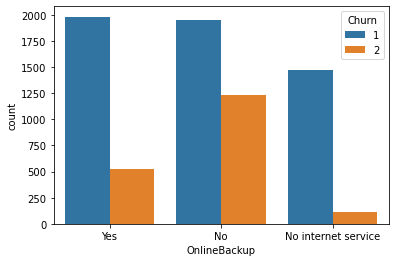

In [47]:
sns.countplot(x = 'OnlineBackup', hue = 'Churn', data = df2)

> R: Quem não tem OnlineBackup fez mais cancelamentos.

#### H11. Quem tem DeviceProtection fez mais cancelamentos.

In [48]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['DeviceProtection']).count()

DeviceProtection
No                     1211
No internet service     113
Yes                     545
Name: Churn, dtype: int64

<AxesSubplot:xlabel='DeviceProtection', ylabel='count'>

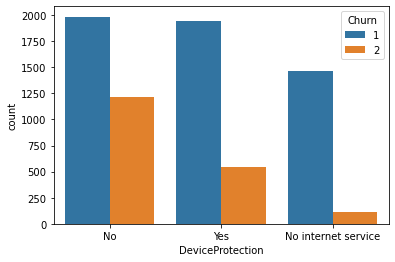

In [49]:
sns.countplot(x = 'DeviceProtection', hue = 'Churn', data = df2)

> R: Quem não tem DeviceProtection fez mais cancelamentos.

#### H12. Quem tem TechSupport fez mais cancelamentos.

In [50]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['TechSupport']).count()

TechSupport
No                     1446
No internet service     113
Yes                     310
Name: Churn, dtype: int64

<AxesSubplot:xlabel='TechSupport', ylabel='count'>

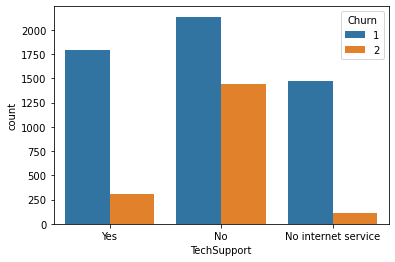

In [51]:
sns.countplot(x = 'TechSupport', hue = 'Churn', data = df2)

> R: Quem não tem TechSupport fez mais cancelamentos.

#### H13. Quem tem StreamingTV fez mais cancelamentos.

In [52]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['StreamingTV']).count()

StreamingTV
No                     942
No internet service    113
Yes                    814
Name: Churn, dtype: int64

<AxesSubplot:xlabel='StreamingTV', ylabel='count'>

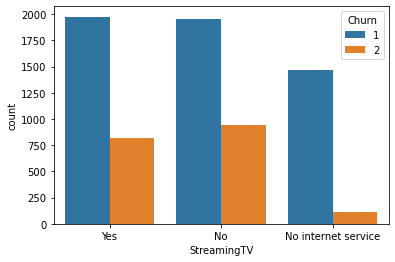

In [53]:
sns.countplot(x = 'StreamingTV', hue = 'Churn', data = df2)

> R: Quem tem StreamingTV fez cancelamentos praticamente na mesma medida de quem não tem StreamingTV. 

#### H14. Quem tem StreamingMovies fez mais cancelamentos.

In [54]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['StreamingMovies']).count()

StreamingMovies
No                     938
No internet service    113
Yes                    818
Name: Churn, dtype: int64

<AxesSubplot:xlabel='StreamingMovies', ylabel='count'>

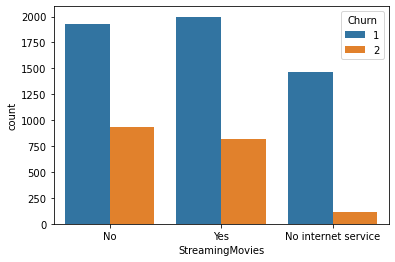

In [55]:
sns.countplot(x = 'StreamingMovies', hue = 'Churn', data = df2)

> R: Quem tem StreamingMovies fez menos cancelamentos de quem não tem StreamingMovies, mas é uma diferença muito pequena.

#### H15. Quem tem contrato month-to-month fez mais cancelamentos.

In [56]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['Contract']).count()

Contract
Month-to-month    1655
One year           166
Two year            48
Name: Churn, dtype: int64

<AxesSubplot:xlabel='Contract', ylabel='count'>

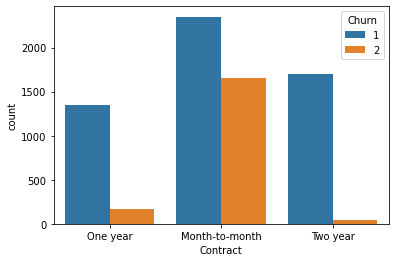

In [57]:
sns.countplot(x = 'Contract', hue = 'Churn', data = df2)

> R: Sim, quem tem contrato month-to-month fazem mais cancelamentos.

#### H16. Quem tem PaperlessBilling fez mais cancelamentos.

In [58]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['PaperlessBilling']).count()

PaperlessBilling
No      469
Yes    1400
Name: Churn, dtype: int64

<AxesSubplot:xlabel='PaperlessBilling', ylabel='count'>

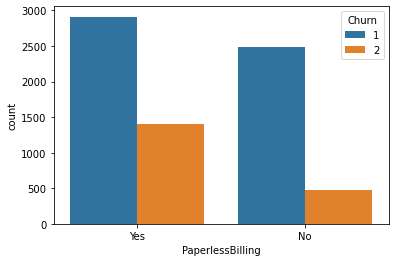

In [59]:
sns.countplot(x = 'PaperlessBilling', hue = 'Churn', data = df2)

> R: Sim, quem tem PaperlessBilling fez mais cancelamentos.

#### H17. Quem tem PaymentMethod Mailed Check fez mais cancelamentos.

In [60]:
df2['Churn'][df2['Churn'] == 2].groupby(by = df2['PaymentMethod']).count()

PaymentMethod
Bank transfer (automatic)     258
Credit card (automatic)       232
Electronic check             1071
Mailed check                  308
Name: Churn, dtype: int64

<AxesSubplot:xlabel='PaymentMethod', ylabel='count'>

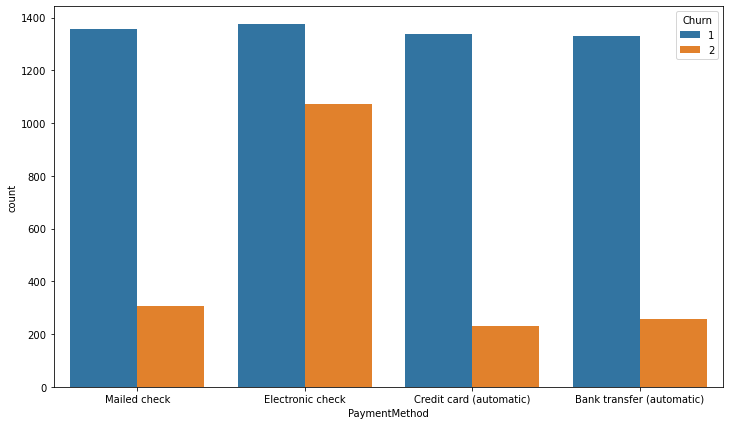

In [61]:
plt.figure(figsize = (12,7))
sns.countplot(x = 'PaymentMethod', hue = 'Churn', data = df2)

> R: Não, quem tem Eletronic Check fez mais cancelamentos.

#### H18. Quem tem o máximo de charges_monthly fez mais cancelamentos.

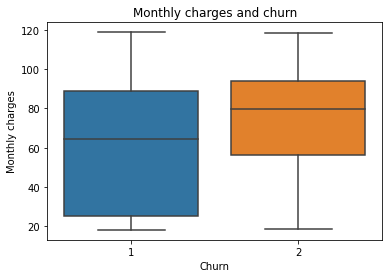

In [62]:
g = sns.boxplot(y='charges_monthly', x='Churn', data=df2)
g.set(xlabel='Churn', ylabel='Monthly charges', title='Monthly charges and churn');

> R: A faixa de cobrança mensal para clientes que não se desligaram começa bem mais baixa do que para os clientes que se desligaram. Preços altos podem ser uma influência para os clientes cancelarem seus contratos.

#### H19. Quem tem o máximo de charges_total fez mais cancelamentos.

<AxesSubplot:xlabel='charges_total_divide', ylabel='count'>

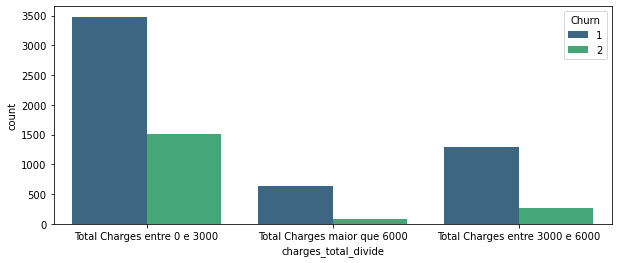

In [63]:
def charges_total(data):
    if data <= 3000:
        return 'Total Charges entre 0 e 3000'
    elif data > 3000 and data <= 6000:
        return 'Total Charges entre 3000 e 6000'
    else:
        return 'Total Charges maior que 6000'
    
df2['charges_total_divide'] = df2['charges_total'].apply(charges_total)

plt.figure(figsize = (10,4))
sns.countplot(data = df2, x = 'charges_total_divide', hue = 'Churn', palette = 'viridis')

> R: A maior concentração de cancelamentos está entre 0 e 3000.

#### H20. Quem tem um plano básico cancela com mais frequência.

Text(0.5, 0, 'Tipo de Plano')

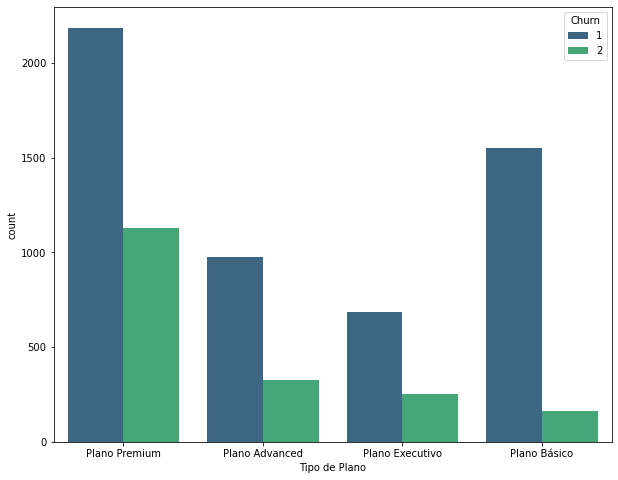

In [64]:
def monthly_plans(data):
    if data <= 30:
        return 'Plano Básico'
    elif data > 30 and data <= 60:
        return 'Plano Advanced'
    elif data > 60 and data <= 100:
        return 'Plano Premium'
    else:
        return 'Plano Executivo'
    
df2['plan_type'] = df2['charges_monthly'].apply(monthly_plans)

plt.figure(figsize = (10,8))
sns.countplot(data = df2, x = 'plan_type', hue = 'Churn', palette = 'viridis')
plt.xlabel('Tipo de Plano')
    

> R: A maior parte dos cancelamentos vem dos planos Premium.

#### H21. A fatura mensal de um cliente aumenta a medida que os encargos aumentam, possivelmente gerando mais cancelamentos (Churn) ?

<AxesSubplot:xlabel='charges_monthly', ylabel='charges_total'>

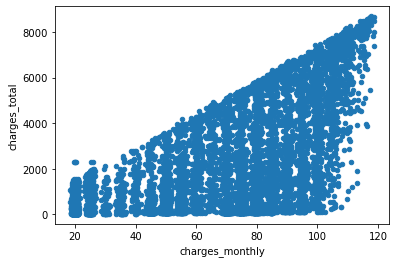

In [65]:
df2[['charges_monthly','charges_total']].plot.scatter(x = 'charges_monthly', y = 'charges_total')

<AxesSubplot:xlabel='charges_monthly', ylabel='charges_total'>

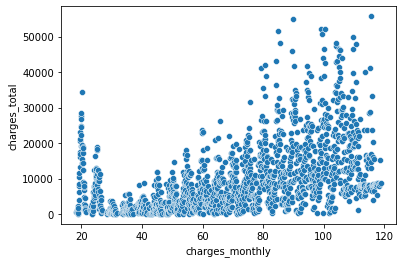

In [66]:
aux1 = df2[['charges_monthly','charges_total']].groupby('charges_monthly').sum().reset_index()
sns.scatterplot(x = 'charges_monthly', y = 'charges_total', data = aux1)

> R: Sim, observamos que os encargos totais aumentam à medida que a fatura mensal de um cliente aumenta.

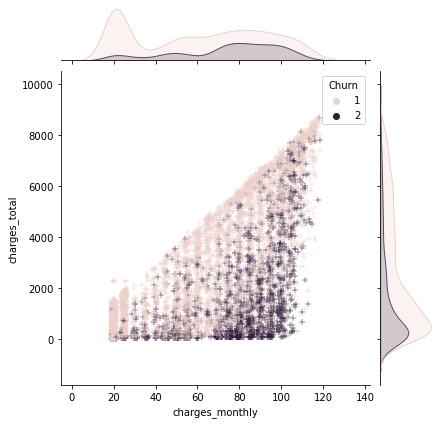

In [67]:
sns.jointplot(data=df2, x='charges_monthly', y='charges_total', hue='Churn', kind='scatter', marker="+")

> R: Observamos que os cancelamentos diminuem quando os clientes gastam mais em serviços, a concentração de cancelamentos está entre 70 a 110 em charges_monthly, até mais ou menos em 2000 em charges_total. 

In [68]:
df2.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,charges_monthly,charges_total,charges_total_divide,plan_type
0,1,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,Yes,Yes,No,One year,Yes,Mailed check,65.60000,593.30000,Total Charges entre 0 e 3000,Plano Premium
1,1,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,Yes,Month-to-month,No,Mailed check,59.90000,542.40000,Total Charges entre 0 e 3000,Plano Advanced
2,2,Male,No,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,73.90000,280.85000,Total Charges entre 0 e 3000,Plano Premium
3,2,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00000,1237.85000,Total Charges entre 0 e 3000,Plano Premium
4,2,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90000,267.40000,Total Charges entre 0 e 3000,Plano Premium


### Análise Multivariada

#### Correlação

In [69]:
df3 = df2.copy()
df3.drop('charges_total_divide', axis = 1, inplace = True)
df3.head()

,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,charges_monthly,charges_total,plan_type
0,1,Female,No,Yes,Yes,9,Yes,No,DSL,No,...,No,Yes,Yes,No,One year,Yes,Mailed check,65.60000,593.30000,Plano Premium
1,1,Male,No,No,No,9,Yes,Yes,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,59.90000,542.40000,Plano Advanced
2,2,Male,No,No,No,4,Yes,No,Fiber optic,No,...,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90000,280.85000,Plano Premium
3,2,Male,Yes,Yes,No,13,Yes,No,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00000,1237.85000,Plano Premium
4,2,Female,Yes,Yes,No,3,Yes,No,Fiber optic,No,...,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90000,267.40000,Plano Premium


In [70]:
df_dummies = pd.get_dummies(df3)
df_dummies.head()

,Churn,tenure,charges_monthly,charges_total,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,...,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,plan_type_Plano Advanced,plan_type_Plano Básico,plan_type_Plano Executivo,plan_type_Plano Premium
0,1,9,65.60000,593.30000,1,0,1,0,0,1,...,0,1,0,0,0,1,0,0,0,1
1,1,9,59.90000,542.40000,0,1,1,0,1,0,...,1,0,0,0,0,1,1,0,0,0
2,2,4,73.90000,280.85000,0,1,1,0,1,0,...,0,1,0,0,1,0,0,0,0,1
3,2,13,98.00000,1237.85000,0,1,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
4,2,3,83.90000,267.40000,1,0,0,1,0,1,...,0,1,0,0,0,1,0,0,0,1


<AxesSubplot:>

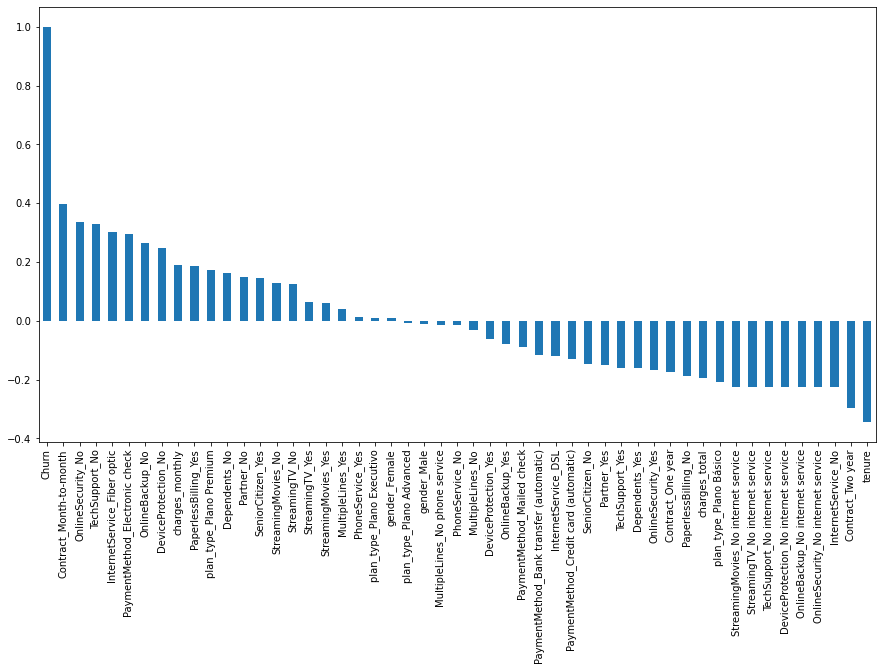

In [71]:
plt.figure(figsize = (15,8))
df_dummies.corr()['Churn'].sort_values(ascending = False).plot(kind = 'bar')

<AxesSubplot:>

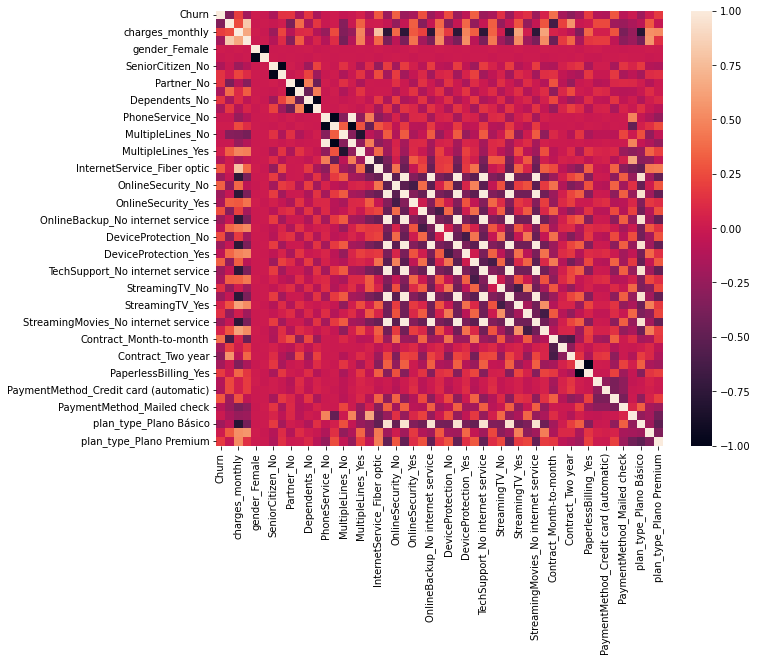

In [72]:
plt.figure(figsize=(10,8))
sns.heatmap(df_dummies.corr())

> Contratos mensais, ausência de segurança online e suporte técnico parecem estar positivamente correlacionados com o churn. Já os contratos de prazo, de dois anos, parecem estar negativamente correlacionados com o churn.

> Curiosamente, serviços como segurança online, streaming de TV, backup online, suporte técnico, etc. sem conexão com a internet parecem estar negativamente relacionados ao churn.

> Vamos explorar os padrões para as correlações acima antes de nos aprofundarmos na modelagem e na identificação das variáveis ​​importantes.

## MACHINE LEARNING MODELING

### Model Building

#### Data Processing / Train - Test Split

In [73]:
X = df_dummies.drop('Churn', axis = 1)
y = df_dummies['Churn']

features = X.columns.values
scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.33, random_state=42)

#### Logistic Regression

              precision    recall  f1-score   support

           1       0.85      0.90      0.88      1810
           2       0.63      0.53      0.57       589

    accuracy                           0.81      2399
   macro avg       0.74      0.71      0.72      2399
weighted avg       0.80      0.81      0.80      2399

Precisão do Modelo:  80.7419758232597


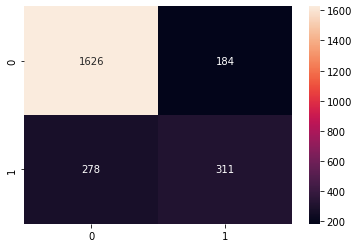

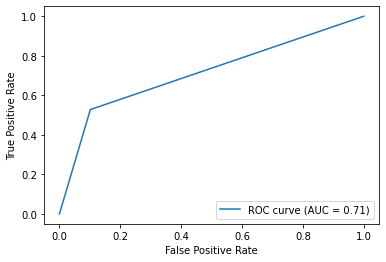

In [75]:
# Training model
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

# Precisão do Modelo
y_pred_log = LR_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_log))
lg = metrics.accuracy_score(y_test, y_pred_log) * 100
print('Precisão do Modelo: ', lg)

# Confusion Matrix
conf_mat_log = metrics.confusion_matrix(y_test, y_pred_log)
sns.heatmap(conf_mat_log, annot = True, fmt = 'g')
plt.show()

# ROC Curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_log, pos_label = 2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

#### Support Vector Machines - SVM

              precision    recall  f1-score   support

           1       0.84      0.91      0.87      1810
           2       0.63      0.47      0.54       589

    accuracy                           0.80      2399
   macro avg       0.73      0.69      0.71      2399
weighted avg       0.79      0.80      0.79      2399

Precisão do Modelo: 80.15839933305544


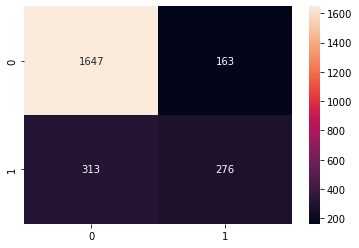

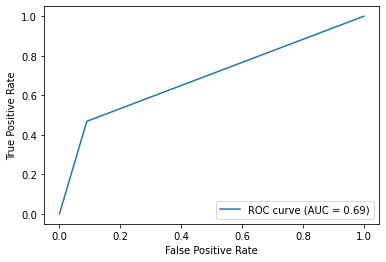

In [76]:
# Training model
svm_model = SVC(random_state=42)
svm_model.fit(X_train, y_train)

# Precisão do Modelo
y_pred_svm = svm_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_svm))
svm = metrics.accuracy_score(y_test,y_pred_svm)*100
print("Precisão do Modelo:", svm)

# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_svm, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

#### Decision Tree

              precision    recall  f1-score   support

           1       0.83      0.82      0.82      1810
           2       0.45      0.47      0.46       589

    accuracy                           0.73      2399
   macro avg       0.64      0.64      0.64      2399
weighted avg       0.73      0.73      0.73      2399

Precisão do Modelo: 73.15548145060443


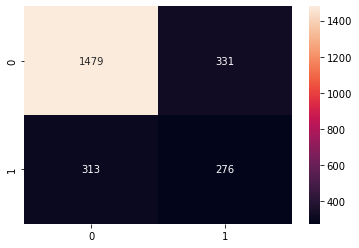

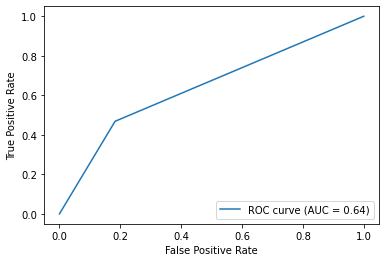

In [77]:
# Training Model
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

# Precisão do Modelo
y_pred_tree = tree_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_tree))
tree=metrics.accuracy_score(y_test,y_pred_tree)*100
print("Precisão do Modelo:", tree)

# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_tree)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_tree, pos_label = 2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

#### Random Forest

              precision    recall  f1-score   support

           1       0.84      0.87      0.85      1810
           2       0.55      0.48      0.51       589

    accuracy                           0.78      2399
   macro avg       0.69      0.68      0.68      2399
weighted avg       0.77      0.78      0.77      2399

Precisão do Modelo: 77.65735723218008


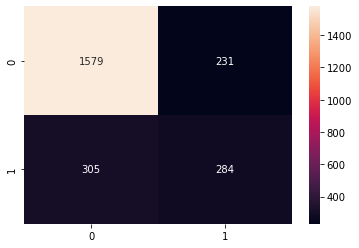

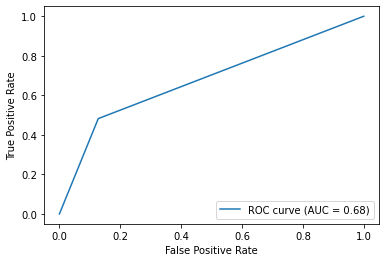

In [78]:
# Training Model
RF_model = RandomForestClassifier(n_estimators=9)
RF_model.fit(X_train, y_train)

# Precisão do Modelo
y_pred_rf = RF_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_rf))
rf=metrics.accuracy_score(y_test,y_pred_rf)*100
print("Precisão do Modelo:", rf)

# confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_rf)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

# ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_rf, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

#### XGBoost

[17:52:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           1       0.84      0.88      0.86      1810
           2       0.57      0.50      0.54       589

    accuracy                           0.79      2399
   macro avg       0.71      0.69      0.70      2399
weighted avg       0.78      0.79      0.78      2399

Precisão do Modelo: 78.53272196748645


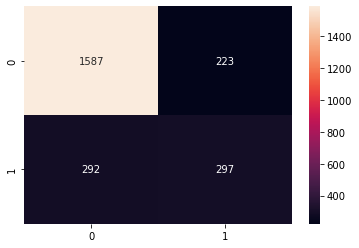

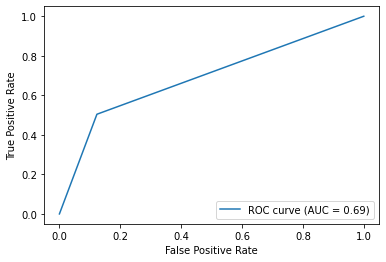

In [79]:
# Training Model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Precisão do Modelo
y_pred_xgb = xgb_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_xgb))
xgb=metrics.accuracy_score(y_test,y_pred_xgb)*100
print("Precisão do Modelo:", xgb)

## confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_xgb, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

#### ADA Boost

              precision    recall  f1-score   support

           1       0.85      0.91      0.88      1810
           2       0.64      0.51      0.57       589

    accuracy                           0.81      2399
   macro avg       0.75      0.71      0.72      2399
weighted avg       0.80      0.81      0.80      2399

Precisão do Modelo: 80.95039599833264


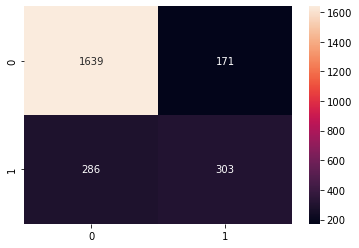

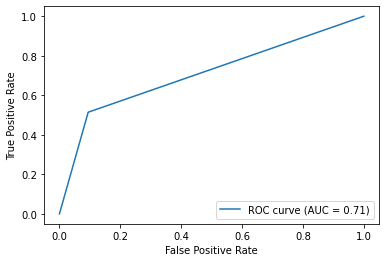

In [80]:
# Training Model
ada_boost_model = AdaBoostClassifier()
ada_boost_model.fit(X_train, y_train)

# Precisão do Modelo
y_pred_ada_boost = ada_boost_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred_ada_boost))
ada_boost=metrics.accuracy_score(y_test,y_pred_ada_boost)*100
print("Precisão do Modelo:", ada_boost)

## confusion matrix
conf_mat = metrics.confusion_matrix(y_test, y_pred_ada_boost)
sns.heatmap(conf_mat, annot=True,fmt="g")
plt.show()

## ROC curve
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_ada_boost, pos_label=2)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='ROC curve')
display.plot()
plt.show()

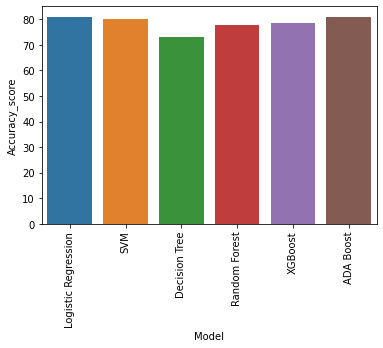

,Model,Accuracy_score
5,ADA Boost,80.95040
0,Logistic Regression,80.74198
1,SVM,80.15840
4,XGBoost,78.53272
3,Random Forest,77.65736
2,Decision Tree,73.15548


In [81]:
models = pd.DataFrame({
    'Model':['Logistic Regression','SVM', 'Decision Tree', 'Random Forest', 'XGBoost', 'ADA Boost'],
    'Accuracy_score':[lg, svm,tree, rf, xgb,ada_boost]
})

models
sns.barplot(x = 'Model', y = 'Accuracy_score', data = models)
plt.xticks(rotation = 90)
plt.show()
models.sort_values(by = 'Accuracy_score', ascending = False)

<AxesSubplot:ylabel='Importance'>

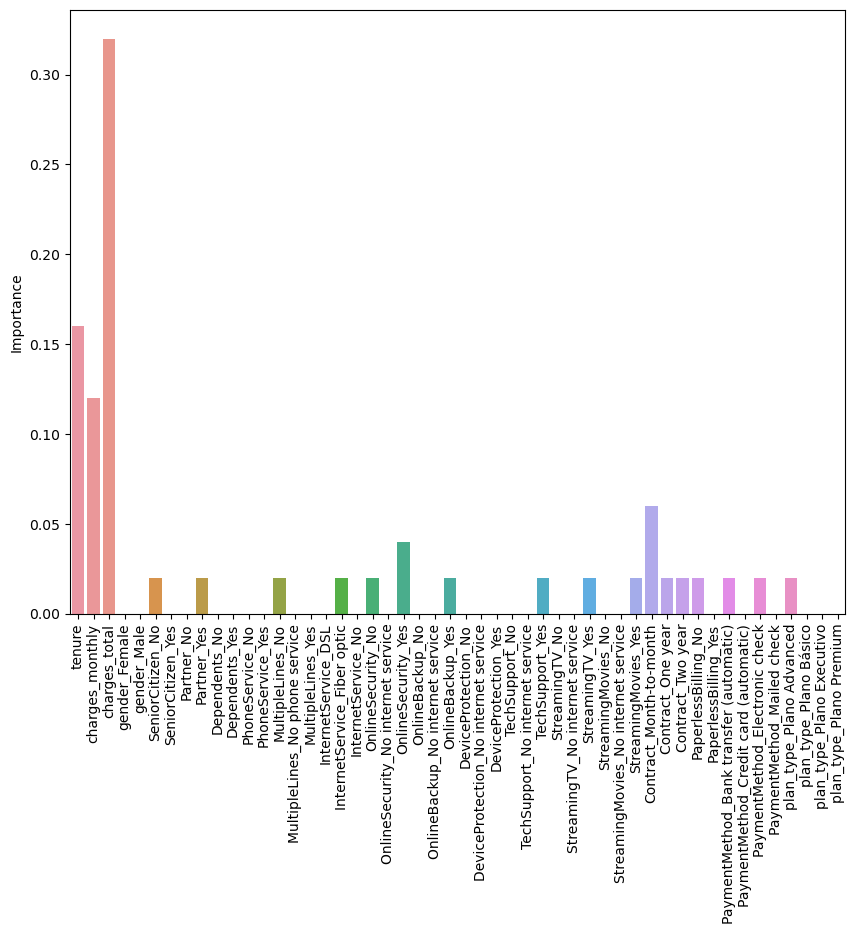

In [94]:
importances = ada_boost_model.feature_importances_
features= pd.DataFrame(index= X.columns,data=ada_boost_model.feature_importances_,columns=['Importance'])
plt.figure(figsize=(10,8),dpi=100)
plt.xticks(rotation=90)
sns.barplot(data=features,x=features.index,y='Importance')

De acordo com o modelo ADA Boost escolhido com maior acurácia, as características mais importantes para prever se um cliente fará churn são:

1. Tenure
2. Monthly Charges
3. Total Charges
4. Contract Month - to - Month